# 0 - Instalation of modules

#Run this cell to have the progress bar
!pip install tqdm
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

In [117]:
%reset

# 1 - Importing modules

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# 2 - Get all files needed

In [2]:
data_folder = "../../Dataset/Movie/"

In [122]:
rating = pd.read_csv(f"{data_folder}ratings.csv").drop(["timestamp"], axis=1)
movie = pd.read_csv(f"{data_folder}movies.csv")

data = pd.merge(movie, rating, on="movieId").drop(["genres", "movieId"], axis=1)
data.shape

(25000095, 3)

# 3 - Transforming data

In [123]:
#On garde les NB_FILM films les plus notés
NB_FILM = 500
keep_title = data["title"].value_counts().sort_values(ascending=False)[:NB_FILM].index
data_title = data[data["title"].isin(keep_title)]
data_title.shape

(10944751, 3)

In [124]:
#On garde les users qui ont données une note sur au moins THRESH_USER % des films
THRESH_USER = 0.25
keep_user = data_title["userId"].value_counts()/NB_FILM >= THRESH_USER
data_title_user = data_title[data_title["userId"].isin(keep_user[keep_user].index)]

In [125]:
#On fait notre pivot table
user_title_df = data_title_user.pivot_table(index="userId", columns="title", values="rating")
user_title_df.to_csv(f"{data_folder}test_for_users.csv")
user_title_df.shape

(24710, 500)

# 4 - Colaborative filtering

In [3]:
#Récupérer les données si elles sont en local
user_title_df = pd.read_csv(f"{data_folder}test_for_users.csv", index_col=0)
user_title_df.shape

(24710, 500)

In [4]:
#Standardisation des lignes pour supprimer les biais
def standardize(row):
    return (row - row.mean())/row.std()

In [5]:
def keep_efficiant_values(cos_df, eps):
    np.fill_diagonal(cos_df.values, 0)
    cos_users_thresh = cos_df[(cos_df>=eps) | (cos_df<=-eps)]
    return cos_users_thresh.dropna(thresh=1, axis=0).dropna(thresh=1, axis=1)

## 4.1 - Users to users

In [6]:
user_title_std = user_title_df.apply(standardize, axis=1).fillna(0)
user_title_std.shape

(24710, 500)

In [7]:
#Création de la matrice de cosinus distance
cos = cosine_similarity(user_title_std)
cos_users_df = pd.DataFrame(cos, index=user_title_std.index, columns=user_title_std.index)
del(cos)

In [8]:
#On devine la note en fonction des candidtats similaires
def guess_rate_cluster(user, title, N):
    rate = 0
    coeff = 0

    for i in cos_users_df.loc[user].sort_values(ascending=False).drop(user).index[:N]:
        r = user_title_df.loc[i, title]
        if not (pd.isnull(r)) and (i != user):
            c = cos_users_df.loc[i, user]
            rate += r*c
            coeff += c
    
    if (coeff != 0):
        return rate/coeff
    else:
        return 2.5

In [9]:
#On devine la note en fonction de tous les candidats
def guess_rate_all(user, title):
    rate = 0
    coef = 0

    for i in user_title_std.index:
        r = user_title_df.loc[i, title]
        if not (pd.isnull(r)) and (i != user):
            c = cos_users_df.loc[user, i]
            rate += c*r
            coef += c

    if (coef == 0):
            return 2.5
    else:   
        return rate/coef

In [ ]:
cos_users_thresh = keep_efficiant_values(cos_users_df, 0.75)
cluster = len(cos_users_thresh) - np.sum(cos_users_thresh.isna(), axis=0).sort_values()

In [37]:
#On compare les deux méthodes
from time import time

compare_time = {}

for N in tqdm([1, 5, 10 , 15]):
    compare_time[f"Cluster {N}"] = {"Cluster" : {"Times" : [], "Rates" : []}, "All" : {"Times" : [], "Rates" : []}}

    keep_index = cluster[(cluster == N) | (cluster == N+1) | (cluster == N-1)].index[:20]
    titles = user_title_df.columns
    sup = []
    positif = []

    for user in tqdm(keep_index, leave=False):
        for title in titles[:100]:
            start = time()
            cluster_rate = guess_rate_cluster(user, title, N)
            cluster_time = time() - start
            compare_time[f"Cluster {N}"]["Cluster"]["Rates"].append(cluster_rate)
            compare_time[f"Cluster {N}"]["Cluster"]["Times"].append(cluster_time)

            start = time()
            all_rate = guess_rate_all(user, title)
            all_time = time() - start
            compare_time[f"Cluster {N}"]["All"]["Rates"].append(all_rate)
            compare_time[f"Cluster {N}"]["All"]["Times"].append(all_time)
            
            sup.append(1) if (cluster_rate - all_rate < 0) else sup.append(0) 
            positif.append(1) if (cluster_time - all_time > 0) else positif.append(0)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

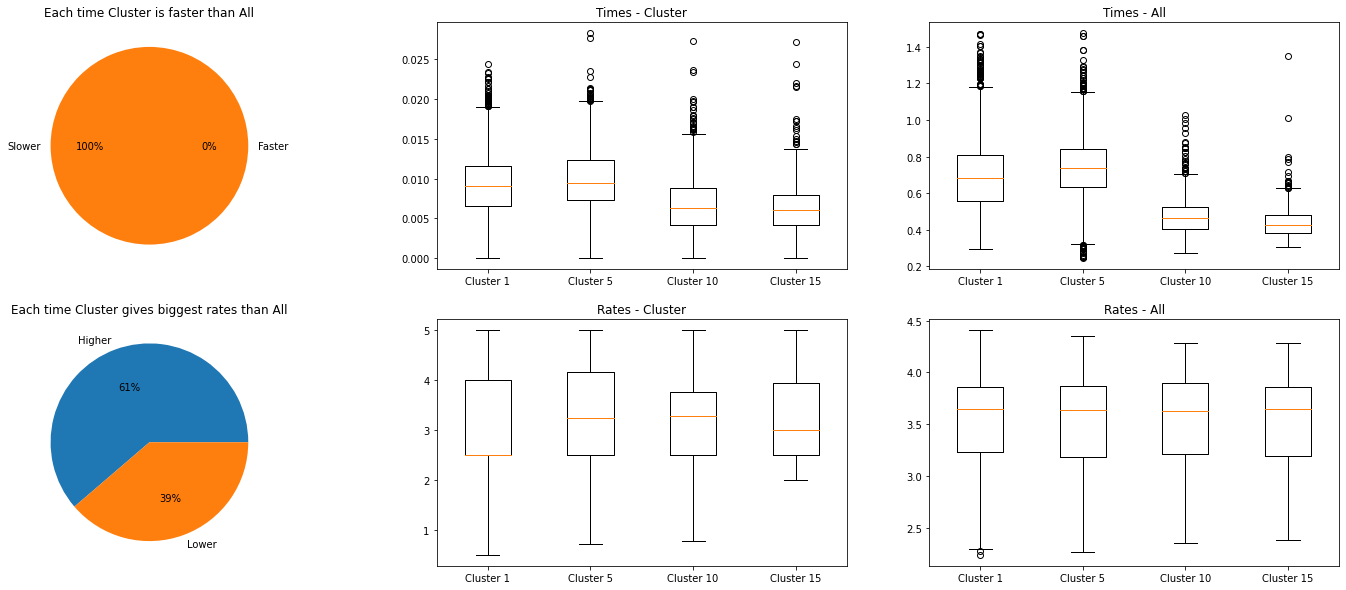

In [39]:
#On affiche graphiquement le comparatif
plt.figure(figsize=(25,10))

k = 1
for stat in ["Times", "Rates"]:
    plt.subplot(2, 3, k)
    if (k == 1):
        n = np.sum(positif)
        plt.pie([n, len(positif)-n], labels=["Faster", "Slower"], autopct='%.0f%%')
        plt.title("Each time Cluster is faster than All")
    elif (k == 4):
        n = np.sum(sup)
        plt.pie([n, len(sup)-n], labels=["Higher", "Lower"], autopct='%.0f%%')
        plt.title("Each time Cluster gives biggest rates than All")
    k += 1

    for method in ["Cluster", "All"]:
        plots = []
        labels = []

        for key in compare_time.keys():
            labels.append(key)
            plots.append(compare_time[key][method][stat])

        plt.subplot(2, 3, k)
        plt.boxplot(plots, labels=labels)
        plt.title(f"{stat} - {method}")

        k += 1

plt.show()

In [29]:
compare = {}

for N in tqdm([1, 5, 10 , 15]):
    compare[f"Cluster {N}"] = {"True" : [], "Cluster" : [], "All" : []}

    keep_index = cluster[(cluster == N) | (cluster == N+1) | (cluster == N-1)].index[:20]
    for user in tqdm(keep_index, leave=False):
        all_rated_film = user_title_df.loc[user].dropna(axis=0)[:50]
        compare[f"Cluster {N}"]["True"] += all_rated_film.values.tolist()
        
        for movie in all_rated_film.index:
            compare[f"Cluster {N}"]["Cluster"].append(guess_rate_cluster(user, movie, N))
            compare[f"Cluster {N}"]["All"].append(guess_rate_all(user, movie))

compare_df = pd.DataFrame.from_dict(compare)
#compare_df.to_csv(f"{data_folder}compare_true_cluster_all.csv")
del(compare)


delta = {"Cluster" : {}, "All" : {}}

for col in compare_df.columns:
    delta["Cluster"][col] = []
    delta["All"][col] = []

    for i in range(len(compare_df[col]["Cluster"])):
        delta["Cluster"][col].append(compare_df[col]["True"][i]-compare_df[col]["Cluster"][i])
        delta["All"][col].append(compare_df[col]["True"][i]-compare_df[col]["All"][i])

compare_delta_df = pd.DataFrame.from_dict(delta)
del(delta)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

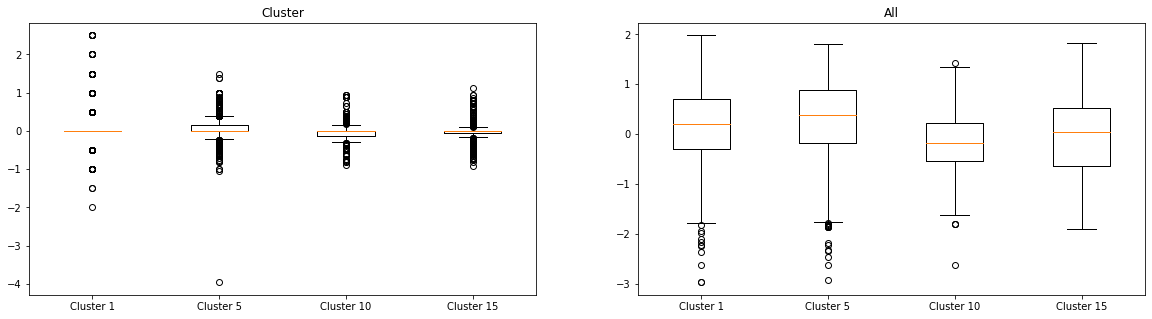

In [30]:
plt.figure(figsize=(20,5))

k = 1
for col in compare_delta_df.columns:
    plt.subplot(1, 2, k)

    plots = []
    labels = []
    for ind in compare_delta_df[col].index:
        plots.append(compare_delta_df[col][ind])
        labels.append(ind)

    plt.boxplot(plots, labels=labels)
    plt.title(col)

    k += 1

plt.savefig("img/compare_true_cluster_all.jpg", dpi=200)
plt.show()

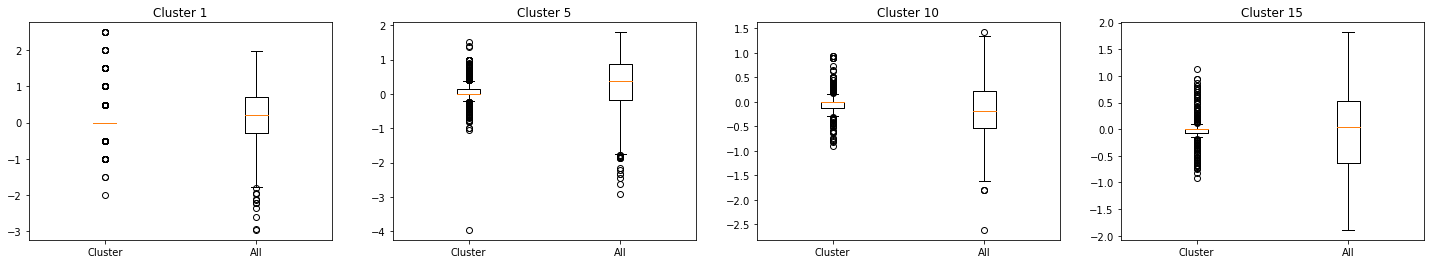

In [36]:
plt.figure(figsize=(25,4))

k = 1
for clust in compare_delta_df.index:
    plt.subplot(1, 4, k)
    plt.boxplot([elem for elem in compare_delta_df.loc[clust]], labels=["Cluster", "All"])
    plt.title(clust)
    k += 1

plt.savefig("img/compare_cluster_all_by_cluster.jpg", dpi=200)
plt.show()

In [12]:
def get_similar_movies_from_users(user_id):
    all_rates = []
    keep_movies = []

    for movie in tqdm(user_title_df.columns):
        if (pd.isnull(user_title_df.loc[user_id, movie])):
            all_rates.append(guess_rate_cluster(user_id, movie, 250))
            keep_movies.append(movie)

    return pd.Series(all_rates, keep_movies).sort_values(ascending=False)

In [14]:
guess_rate_cluster(3, "Young Master, The (Shi di chu ma) (1980)", 250)

3.5037574588767866

In [15]:
get_similar_movies_from_users(3)

  0%|          | 0/10000 [00:00<?, ?it/s]

Cats Don't Dance (1997)                                            5.0
Night in Casablanca, A (1946)                                      5.0
That Munchhausen (1979)                                            5.0
All the Mornings of the World (Tous les matins du monde) (1991)    5.0
Somewhere in Time (1980)                                           5.0
                                                                  ... 
Ghost Dad (1990)                                                   0.5
Leningrad Cowboys Go America (1989)                                0.5
Stomp the Yard (2007)                                              0.5
The Hate U Give (2018)                                             0.5
Boy Who Could Fly, The (1986)                                      0.5
Length: 9346, dtype: float64

## 4.2 - Movie to movie

In [109]:
user_title_std = user_title_df.apply(standardize, axis=0).fillna(0)
user_title_std.shape

(9441, 10000)

In [110]:
#Création de la matrice de cosinus distance
cos = cosine_similarity(user_title_std.T)
cos_movies_df = pd.DataFrame(cos, index=user_title_std.columns, columns=user_title_std.columns)
del(cos)

In [118]:
def get_similar_movies_from_movies(user_id):
    similar_movies = pd.DataFrame()

    movies_rates = user_title_df.loc[user_id].dropna()
    movies = movies_rates.index
    rates = movies_rates.values
    user = [(movies[i], rates[i]) for i in range(len(rates))]

    for movie, rate in tqdm(user):
        movie_list = (cos_movies_df.loc[:, movie]*(rate-2.5)).sort_values(ascending=False)
        similar_movies = similar_movies.append(movie_list)

    
    similar_movies = similar_movies.T.drop([movie for movie, rate in user], axis=0)
    return similar_movies.sum(axis=1).sort_values(ascending=False)

In [172]:
get_similar_movies_from_movies(3)

  0%|          | 0/654 [00:00<?, ?it/s]

Spider-Man 2 (2004)                                                                               105.501590
Ocean's Thirteen (2007)                                                                            99.012323
National Treasure (2004)                                                                           98.338923
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)     96.549589
Up (2009)                                                                                          95.769170
                                                                                                     ...    
Secret Agent, The (1996)                                                                           -0.101597
Fire Within, The (Feu follet, Le) (1963)                                                           -0.221729
Shanghai Surprise (1986)                                                                           -0.381326
Distant (Uzak) (200

## 4.3 - Mix